In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from model.segformer_simple import Segformerwithcarbon
from dataset_segwithcarbon import CarbonDataset, CarbonDataset_csv
from model.util import select_device, mix_patch
from tqdm import tqdm
from model.metrics import CarbonLoss , CarbonLossWithRMSE
import os
import logging

def validate(model, device, loss_fn, loader, domain="Forest"):
    model.eval()
    val_stats = {'total_loss': 0.0, 'total_cls_loss': 0.0, 'total_reg_loss': 0.0,
                 'total_acc_c': 0.0, 'total_acc_r': 0.0, 'total_miou': 0.0, 'total_rmse': 0.0, 'batches': 0}
    
    with torch.no_grad():
        for x, carbon, gt in tqdm(loader, desc=f"Validating {domain}"):
            x, carbon, gt = x.to(device), carbon.to(device), gt.to(device)
            gt_pred, carbon_pred = model(x)
            total_loss, cls_loss, reg_loss, acc_c, acc_r, miou, rmse = loss_fn(gt_pred, gt.squeeze(1), carbon_pred, carbon)
            
            val_stats['total_loss'] += total_loss.item()
            val_stats['total_cls_loss'] += cls_loss.item()
            val_stats['total_reg_loss'] += reg_loss.item()
            val_stats['total_acc_c'] += acc_c
            val_stats['total_acc_r'] += acc_r
            val_stats['total_miou'] += miou
            val_stats['total_rmse'] += rmse
            val_stats['batches'] += 1

    return {k: v / val_stats['batches'] for k, v in val_stats.items() if k != 'batches'}

def get_transforms(label_size):
    image_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    sh_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    label_transform = transforms.Compose([
        transforms.Resize((label_size, label_size)),
    ])
    return image_transform, sh_transform, label_transform

device = select_device()

In [2]:
label_size = 256 // 4
image_transform, sh_transform, label_transform = get_transforms(label_size)
forest_fp = "val_AP25_Forest_IMAGE.csv"
city_fp = "val_AP25_City_IMAGE.csv"
pretrain_path = "checkpoints\SegFomer\SegFomerB0AP25_Forest_64_best.pth"
batch_size = 12
clss_num = 4

forest_dataset = CarbonDataset_csv(forest_fp, image_transform, sh_transform, label_transform, mode="Valid",combine=True)
forest_loader = DataLoader(forest_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

city_dataset = CarbonDataset_csv(city_fp, image_transform, sh_transform, label_transform, mode="Valid",combine=True)
city_loader = DataLoader(city_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

def update_state_dict(state_dict):
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith('to_segmentation.'):
            new_key = 'to_segmentation.to_segmentation.' + key[len('to_segmentation.'):]
            new_state_dict[new_key] = value
        elif key.startswith('to_regression.'):
            new_key = 'to_regression.to_regression.' + key[len('to_regression.'):]
            new_state_dict[new_key] = value
        else:
            new_state_dict[key] = value
    return new_state_dict

FOLDER_PATH = {
    'AP10_Forest_IMAGE.csv': 4,
    'AP25_Forest_IMAGE.csv': 4,   
    'AP10_City_IMAGE.csv': 4,
    'AP25_City_IMAGE.csv': 4,
    'SN10_Forest_IMAGE.csv': 4,
}

# 상태 사전 로드
state_dict = torch.load(pretrain_path,map_location=torch.device('cpu'))

# 상태 사전 업데이트
# updated_state_dict = update_state_dict(state_dict)

model_args = {
    'dims': (32, 64, 160, 256),
    'heads': (1, 2, 5, 8),
    'ff_expansion': (8, 8, 4, 4),
    'reduction_ratio': (8, 4, 2, 1),
    'num_layers': 2,
    'decoder_dim': 256,
    'channels': 4,
    'num_classes': clss_num,
    'stage_kernel_stride_pad': [(7, 4, 3), (3, 2, 1), (3, 2, 1), (3, 2, 1)],
}

model = Segformerwithcarbon(**model_args)
model.load_state_dict(state_dict,strict = True)
model.to(device)
loss_fn = CarbonLossWithRMSE(num_classes=clss_num, cls_lambda=1, reg_lambda=0.0005).to(device)


In [3]:
forest_val_stats = validate(model, device, loss_fn, forest_loader)
print(forest_val_stats)
city_val_stats = validate(model, device, loss_fn, city_loader, domain="City")
print(city_val_stats)


Validating Forest: 100%|██████████| 134/134 [00:31<00:00,  4.29it/s]


{'total_loss': 1.9660399547263758, 'total_cls_loss': 0.48672617449244454, 'total_reg_loss': 2958.6274061060662, 'total_acc_c': 0.6633932958451432, 'total_acc_r': -1515.0539824116042, 'total_miou': tensor(0.3877), 'total_rmse': 0.21790408677201822}


Validating City: 100%|██████████| 34/34 [00:26<00:00,  1.30it/s]

{'total_loss': 0.29114516495781784, 'total_cls_loss': 0.13544595351113992, 'total_reg_loss': 311.39840810439165, 'total_acc_c': 0.9644836396881438, 'total_acc_r': 0.9180287683997331, 'total_miou': tensor(0.5381), 'total_rmse': 0.06851618572928807}


In [4]:
val_stats = {k: (forest_val_stats[k] + city_val_stats[k]) / 2 for k in forest_val_stats}
print(val_stats)

{'total_loss': 1.128592559842097, 'total_cls_loss': 0.31108606400179223, 'total_reg_loss': 1635.012907105229, 'total_acc_c': 0.8139384677666435, 'total_acc_r': -757.0679768216022, 'total_miou': tensor(0.4629), 'total_rmse': 0.14321013625065315}


In [5]:
from thop import profile
from thop import clever_format
forest_loader = DataLoader(forest_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)
city_loader = DataLoader(city_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)
# Get a batch of data
batch = next(iter(city_loader))

# Extract the input from the batch
x , carbon , gt = batch
x = x.to(device)
carbon = carbon.to(device)
gt = gt.to(device)

# Pass the input through the model
gt_pred,carbon_pred = model(x)

# Print the output
print(gt_pred.shape)
print(carbon_pred.shape)

try:
    flops, params = profile(model, inputs=(x,))
except Exception as e:
    print(f"Error during profiling: {e}")
    print(f"Input shape: {x.shape}")

# FLOPs를 사람이 읽기 쉬운 형식으로 변환
flops, params = clever_format([flops, params], "%.3f")

print(f"FLOPs: {flops}")
print(f"파라미터 수: {params}")


torch.Size([1, 4, 64, 64])
torch.Size([1, 1, 64, 64])
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
FLOPs: 4.357G
파라미터 수: 7.978M


산림지

In [3]:
import torch
import numpy as np
forest_loader = DataLoader(forest_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)

# Fetch one batch from the data loader
batch = next(iter(forest_loader))


# Access the input data and labels
image_sh , carbon , gt = batch
image_sh = image_sh.to(device)
gt = gt.to(device)
carbon = carbon.to(device)

gt_pred, carbon_pred = model(image_sh)

image_sh = image_sh.cpu()
gt = gt.cpu()
carbon = carbon.cpu()
gt_pred = gt_pred.cpu()
carbon_pred = carbon_pred.cpu()

# 정규화된 이미지를 원래 스케일로 변환
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # for t, m, s in zip(tensor, mean, std):
    #     t.mul_(s).add_(m)
    return tensor

# 이미지 denormalize
image = denormalize(image_sh[0,:3,:,:]).permute(1,2,0).numpy()
# 이미지 값을 0-1 범위로 클리핑
#image = np.clip(image, 0, 1)

gt_image = gt[0,:,:].permute(1,2,0).squeeze().numpy()
# 예시로 carbon_pred를 사용합니다.
gt_pred_softmax = torch.softmax(gt_pred, dim=1)
_, predicted_labels = torch.max(gt_pred_softmax, dim=1)
gt_pred_image = predicted_labels.squeeze().detach().cpu().numpy()

# 사용자 정의 컬러 맵 만들기
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00']  # 0, 1, 2, 3에 해당하는 색상
cmap_custom = plt.cm.colors.ListedColormap(colors)

# Normalize 설정
norm = plt.cm.colors.Normalize(vmin=0, vmax=3)  # 데이터 값 범위에 따라 색상을 매핑하기 위해 정규화
fig, ax = plt.subplots(2, 3, figsize=(15, 10))


carbon_im = carbon[0].permute(1,2,0).detach().numpy()
carbon_pred_im = carbon_pred[0].permute(1,2,0).detach().numpy()

# 첫 번째 행
ax[0, 0].imshow(image)
ax[0, 0].set_title('Input Image')
ax[0, 0].axis('off')
ax[0, 1].imshow(gt_image, cmap=cmap_custom, norm=norm)
ax[0, 1].set_title('Ground Truth')
ax[0, 1].axis('off')
ax[0, 2].imshow(gt_pred_image, cmap=cmap_custom, norm=norm)
ax[0, 2].set_title('Prediction')
ax[0, 2].axis('off')

# 두 번째 행
ax[1, 0].imshow(image)
ax[1, 0].set_title('Image')
ax[1, 0].axis('off')
ax[1, 1].imshow(carbon_im)
ax[1, 1].set_title('Carbon')
ax[1, 1].axis('off')
ax[1, 2].imshow(carbon_pred_im)
ax[1, 2].set_title('Carbon Prediction')
ax[1, 2].axis('off')

plt.tight_layout()
plt.show()

도심지

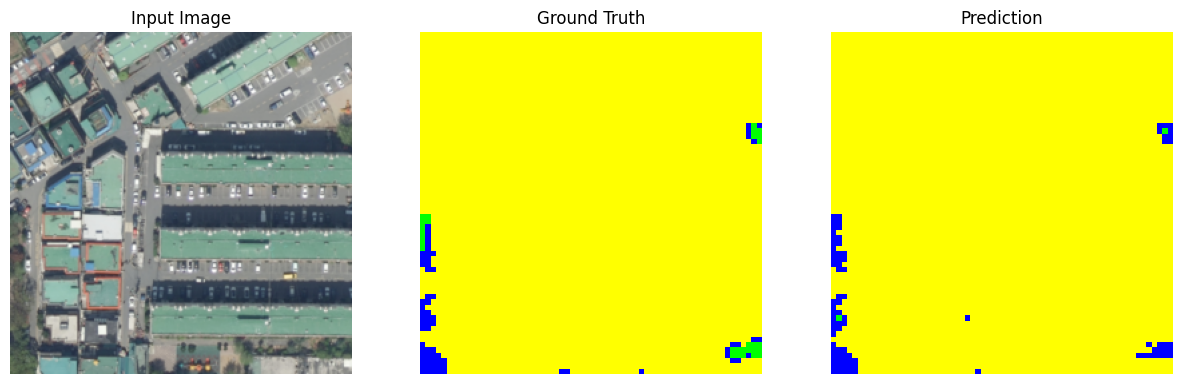

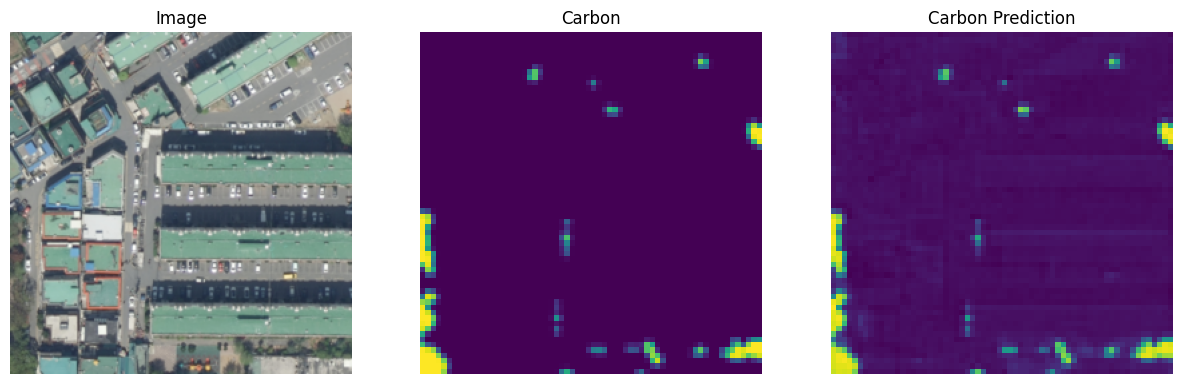

In [ ]:
import torch
import numpy as np

city_loader = DataLoader(city_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)
# Fetch one batch from the data loader
batch = next(iter(city_loader))

# Access the input data and labels
image_sh , carbon , gt = batch
image_sh = image_sh.to(device)
gt = gt.to(device)
carbon = carbon.to(device)

gt_pred, carbon_pred = model(image_sh)

image_sh = image_sh.cpu()
gt = gt.cpu()
carbon = carbon.cpu()
gt_pred = gt_pred.cpu()
carbon_pred = carbon_pred.cpu()

# 정규화된 이미지를 원래 스케일로 변환
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # for t, m, s in zip(tensor, mean, std):
    #     t.mul_(s).add_(m)
    return tensor

# 이미지 denormalize
image = denormalize(image_sh[0,:3,:,:]).permute(1,2,0).numpy()
# 이미지 값을 0-1 범위로 클리핑
# image = np.clip(image, 0, 1)

gt_image = gt[0,:,:].permute(1,2,0).squeeze().numpy()
# 예시로 carbon_pred를 사용합니다.
gt_pred_softmax = torch.softmax(gt_pred, dim=1)
_, predicted_labels = torch.max(gt_pred_softmax, dim=1)
gt_pred_image = predicted_labels.squeeze().detach().cpu().numpy()

# 사용자 정의 컬러 맵 만들기
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00']  # 0, 1, 2, 3에 해당하는 색상
cmap_custom = plt.cm.colors.ListedColormap(colors)

# Normalize 설정
norm = plt.cm.colors.Normalize(vmin=0, vmax=3)  # 데이터 값 범위에 따라 색상을 매핑하기 위해 정규화

fig, ax = plt.subplots(2, 3, figsize=(15, 10))


carbon_im = carbon[0].permute(1,2,0).detach().numpy()
carbon_pred_im = carbon_pred[0].permute(1,2,0).detach().numpy()

# 첫 번째 행
ax[0, 0].imshow(image)
ax[0, 0].set_title('Input Image')
ax[0, 0].axis('off')
ax[0, 1].imshow(gt_image, cmap=cmap_custom, norm=norm)
ax[0, 1].set_title('Ground Truth')
ax[0, 1].axis('off')
ax[0, 2].imshow(gt_pred_image, cmap=cmap_custom, norm=norm)
ax[0, 2].set_title('Prediction')
ax[0, 2].axis('off')

# 두 번째 행
ax[1, 0].imshow(image)
ax[1, 0].set_title('Image')
ax[1, 0].axis('off')
ax[1, 1].imshow(carbon_im)
ax[1, 1].set_title('Carbon')
ax[1, 1].axis('off')
ax[1, 2].imshow(carbon_pred_im)
ax[1, 2].set_title('Carbon Prediction')
ax[1, 2].axis('off')

plt.tight_layout()
plt.show()